In [0]:
# default_exp data.exploratory

# Exploration of your data

> This module comprises all the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

In [2]:
!pip install dit
!pip install sentencepiece

In [0]:
# export
# Imports
import pandas as pd
import sentencepiece as sp
import dit

from collections import Counter
from scipy.stats import sem, t
from numpy import mean
from numpy import std
import statistics as stat
import matplotlib.pyplot as plt


# TODO: Remove when mongo call is implemented
import os

In [0]:
# #hide
# from nbdev.showdoc import *

In [0]:
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo():
    corpus_data = {'file_name': [], 'data_type': [], 'contents': []}
    path = "./requirements"
    for file in os.listdir(path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('req')
        with open (os.path.join(path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    path = "./source_code"
    for file in os.listdir(path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('src')
        with open (os.path.join(path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    path = "./tests"
    for file in os.listdir(path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('test')
        with open (os.path.join(path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [0]:
# export
def df_to_txt_file(df, output, cols):
    """Converts a dataframe into a text file that SentencePiece can use to train a BPE model"""
    if cols is None: cols = list(df.columns)
    merged_df = pd.concat([df[col] for col in cols])
    
    with open(output + '_text.txt', 'w') as f:
        f.write('\n'.join(list(merged_df)))
    return output + '_text.txt'

In [0]:
# export
def gen_sp_model(df, output, model_name, cols=None):
    """Trains a SentencePiece BPE model from a pandas dataframe"""
    fname = df_to_txt_file(df, output, cols)
    sp.SentencePieceTrainer.train(f'--input={fname} --model_prefix={output + model_name} --hard_vocab_limit=false --model_type=bpe')
    return output + model_name

In [0]:
# export
def encode_text(text, model_prefix):
    '''Encodes text using a pre-trained sp model, returns the occurrences of each token in the text'''
    sp_processor = sp.SentencePieceProcessor()
    sp_processor.Load(f"{model_prefix}.model")
    token_counts = Counter()
    encoding = sp_processor.encode_as_pieces(text)
    for piece in encoding:
        token_counts[piece] += 1
    return token_counts

In [0]:
def dit_shannon(token_counts):
    '''Takes in a counter object of token occurrences, computes the entropy of the corpus that produced it'''
    num_tokens = 0
    for token in token_counts:
        num_tokens += token_counts[token]
    outcomes = list(set(token_counts.elements()))
    frequencies = []
    for token in token_counts:
        frequencies.append((token_counts[token])/num_tokens)
    d = dit.ScalarDistribution(outcomes, frequencies)
    return dit.shannon.entropy(d)

In [0]:
def entropies_of_df_entries(df, col, model_prefix):
    '''Returns a list of the entropies of each entry in a dataframe column'''
    entropies = []
    for data in df[col]:
        token_counts= encode_text(data, model_prefix)
        entropies.append(dit_shannon(token_counts))
    return entropies

In [0]:
# TODO: Finish this such that is finds the entropy of the entire corpus \
#       and preserves the individual token frequencies so that we can   \
#      compute the most common tokens

# def entropy_of_whole_corpus(df, col, model_prefix):
#     '''Returns a dictionary of the entropies of each token in a dataframe corpus'''
#     entropies = {}
#     token_counts = encode_text(pd.concat[col], model_prefix)
#     entropies.append(dit_shannon(token_counts))
#     return entropies

In [0]:
# export
# TODO: Do we need this function?
import math
def manual_shannon(token_freqs):
    sum = 0
    for i in token_freqs:
        sum += i * math.log(1/i, 2)
    return sum

In [0]:
#export
# TODO: Do we need this function?
def sort_token_data(token_data):
    return sorted(token_data.items() ,  key=lambda x: x[1]["Occurrences"])

# EXPLORATORY ANALYSIS

## LIBest Corpus

In [0]:
# Create a dataframe of the requirements, source code and test case data for LIBest
# Create a sentencepiece model using the entire LIBest corpus
LIB_corpus_df = simulate_getting_dataframes_from_mongo()
LIB_model = gen_sp_model(LIB_corpus_df, output='LIBest', model_name='_sp_bpe_modal', cols=['contents'])

## Looking at Individual Files

In [0]:
# Use the model to compute each file's entropy
LIB_entropies = entropies_of_df_entries(LIB_corpus_df, 'contents', LIB_model)

In [16]:
# Calculate metrics on the LIBest corpus entropies
print("Max entropy:", max(LIB_entropies))
print("Min entropy:", min(LIB_entropies))
print("Average entropy:", mean(LIB_entropies))
print("Median entropy:", stat.median(LIB_entropies))

print("Entropy Standard Deviation:", std(LIB_entropies))

confidence = 0.95
n = len(LIB_entropies)
m = mean(LIB_entropies)
std_err = sem(LIB_entropies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(f"95% of entropies fall within {start} and {end}")

Max entropy: 8.737176307586141
Min entropy: 3.979797585487148
Average entropy: 6.910210324792078
Median entropy: 7.086176924292342
Entropy Standard Deviation: 1.0693292402540278
95% of entropies fall within 6.680984141366826 and 7.1394365082173294


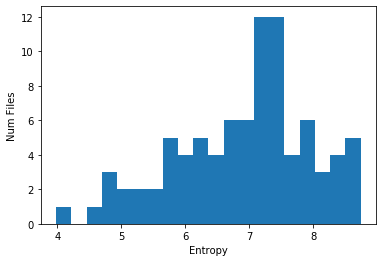

In [17]:
# Create a histogram of the entropy distribution
plt.hist(LIB_entropies, bins = 20)
plt.ylabel("Num Files")
plt.xlabel("Entropy")
plt.show()

## Looking at the Corpus as a Whole

# Scratch Code (Testing)

In [11]:
from collections import Counter
tok_counts = Counter()
tok_counts['hi'] += 1
tok_counts['ooooo'] += 1
tok_counts['ooooo'] += 1
# print(p)
# print(len(p))
# for i in p.elements():
#   print(i)
print(list(set(tok_counts.elements())))



num_tokens = 3
frequencies = [count/num_tokens for token in outcomes for count in ]

['ooooo', 'hi']


In [17]:
freq = [.8, .1, .1]
# toks = [str(i) for i in range(len(freq))]
toks = ('a', 'bb', 'ccc')

d = dit.ScalarDistribution(toks, freq)
print(dit.shannon.entropy(d))
print(manual_shannon(freq))



0.9219280948873623
0.9219280948873625


In [43]:
a_corpus = {'file_name': ["aa", "ab", "ac"], 'contents': [1, 2, 3]}
a_df = pd.DataFrame(data = a_corpus)
b_corpus = {'file_name': ["ba", "bb", "bc"], 'contents': [4, 5, 6]}
b_df = pd.DataFrame(data = b_corpus)
c_corpus = {'file_name': ["ca", "cb", "cc"], 'contents': [7, 8, 9]}
c_df = pd.DataFrame(data = c_corpus)

corpus_data = {'a':a_df, 'b':b_df, 'd':c_df}

# corpus_contents = pd.Series([])
corpus_contents = []
for data_type in corpus_data.keys():
    corpus_contents.append(corpus_data[data_type].contents)
print(pd.concat(corpus_contents))


# print([corpus_data[i] for i in corpus_data.keys()])

# merged_corpus = pd.concat([df.contents for df in corpus_data[data_type] for data_type in corpus_data.keys()])
# merged_corpus = pd.concat([df for data_type in corpus_data.keys() for df in corpus_data[data_type].contents])
# flatten_matrix = [val for sublist in matrix for val in sublist] 

# something = [df["contents"] for data_type in corpus_data.keys() for df in corpus_data[data_type]]
# print(something)
# print(pd.concat(something))
# print([i for i in range(10)])

# print(merged_df)
# print(pd.concat([a_df.contents, b_df.contents]))

0    1
1    2
2    3
0    4
1    5
2    6
0    7
1    8
2    9
Name: contents, dtype: int64


In [0]:
#Rank the system/datasets according to the confidence intervals
#Compute the confidence intervals for all cross-entropy values
#Rank the systems/datasets according to cross-entropy values
#Top 50 most frequent tokens of each system and corpus (one system has generally two corpora)
#Top 50 least frequent tokes of each system and corpus
#What are the tokens that are in the target and not in the source (and the other way around)? Compute the distribution for those tokens
#What are the mutual tokens (source and target)? please compute distribution
#-Compute confidence intervals for the software metrics on source code (e.g., cyclo, loc, lcom5)


In [0]:
Visualize

In [0]:
Push updated fields to Mongo